In [2]:
import polars as pl
from sklearn import svm, neighbors, preprocessing, cluster
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
import math
from sklearn.ensemble import BaggingRegressor
from imblearn import under_sampling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
df = pl.read_csv("./data/EEG_Eye_State_Classification.csv")
df.head()

AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.9,4393.85,0
4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.1,0
4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
4328.72,4011.79,4296.41,4155.9,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.9,4627.69,4210.77,4244.1,4212.82,4288.21,4632.82,4398.46,0


<Axes: ylabel='O2'>

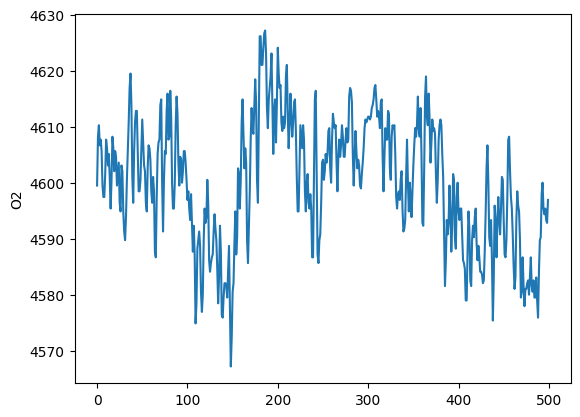

In [7]:
sns.lineplot(x=range(len(df.get_column("O2")[2000:2500])), y=df.get_column("O2")[2000:2500])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop("eyeDetection").to_numpy(),
    df.get_column("eyeDetection").to_numpy(),
    test_size=0.2,
    random_state=48,
)
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [61]:
params_loose = {
    "C": [math.pow(2, exp) for exp in range(-3, 5)],
    "gamma": [math.pow(2, exp) for exp in range(-3, 5)],
}
best_params_loose = model = (
    GridSearchCV(svm.SVC(), params_loose, verbose=2).fit(x_train, y_train).best_params_
)
best_params_loose  # {'C': 8.0, 'gamma': 4.0}

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ...............................C=0.125, gamma=0.125; total time=   2.5s
[CV] END ...............................C=0.125, gamma=0.125; total time=   2.5s
[CV] END ...............................C=0.125, gamma=0.125; total time=   1.5s
[CV] END ...............................C=0.125, gamma=0.125; total time=   1.3s
[CV] END ...............................C=0.125, gamma=0.125; total time=   1.4s
[CV] END ................................C=0.125, gamma=0.25; total time=   1.3s
[CV] END ................................C=0.125, gamma=0.25; total time=   1.3s
[CV] END ................................C=0.125, gamma=0.25; total time=   1.3s
[CV] END ................................C=0.125, gamma=0.25; total time=   1.5s
[CV] END ................................C=0.125, gamma=0.25; total time=   3.8s
[CV] END .................................C=0.125, gamma=0.5; total time=   3.0s
[CV] END .................................C=0.1

{'C': 8.0, 'gamma': 4.0}

In [74]:
params_fine = {
    "C": [math.pow(2, exp / 4) for exp in range(9, 16)],
    "gamma": [math.pow(2, exp / 4) for exp in range(5, 12)],
}
best_params_fine = model = (
    GridSearchCV(svm.SVC(), params_fine, verbose=2).fit(x_train, y_train).best_params_
)
best_params_fine  # {'C': 13.454342644059432, 'gamma': 3.363585661014858}

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV] END .......C=4.756828460010884, gamma=2.378414230005442; total time=   2.4s
[CV] END .......C=4.756828460010884, gamma=2.378414230005442; total time=   1.9s
[CV] END .......C=4.756828460010884, gamma=2.378414230005442; total time=   3.0s
[CV] END .......C=4.756828460010884, gamma=2.378414230005442; total time=   3.1s
[CV] END .......C=4.756828460010884, gamma=2.378414230005442; total time=   5.0s
[CV] END ......C=4.756828460010884, gamma=2.8284271247461903; total time=   5.1s
[CV] END ......C=4.756828460010884, gamma=2.8284271247461903; total time=   6.0s
[CV] END ......C=4.756828460010884, gamma=2.8284271247461903; total time=   6.0s
[CV] END ......C=4.756828460010884, gamma=2.8284271247461903; total time=   3.2s
[CV] END ......C=4.756828460010884, gamma=2.8284271247461903; total time=   4.7s
[CV] END .......C=4.756828460010884, gamma=3.363585661014858; total time=   9.8s
[CV] END .......C=4.756828460010884, gamma=3.36

{'C': 13.454342644059432, 'gamma': 3.363585661014858}

In [8]:
model = svm.SVC(C=10, gamma=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred), math.sqrt(
    mean_squared_error(y_test, y_pred)
), math.sqrt(mean_squared_error(model.predict(x_train), y_train)), roc_auc_score(y_test, y_pred)

(0.9235647530040053,
 0.2764692514475971,
 0.23890605155295844,
 0.9221061547148504)